# Bootstrap analysis of all task's subtypes

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import plotting

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [5]:
#  Set path
path_root = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/pheno'
mask_path = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/mask_roi_resample.nii.gz'

In [6]:
df_stack = pd.read_csv(os.path.join(path_root,'all_subtype_stack.csv'))

In [7]:
df_stack.head()

,sub1_fear,sub2_fear,sub3_fear,sub4_fear,sub5_fear,sub1_contrast_loss_event_vs_neut_event,sub2_contrast_loss_event_vs_neut_event,sub3_contrast_loss_event_vs_neut_event,sub4_contrast_loss_event_vs_neut_event,sub5_contrast_loss_event_vs_neut_event,...,sub1_places,sub2_places,sub3_places,sub4_places,sub5_places,sub1_2bk,sub2_2bk,sub3_2bk,sub4_2bk,sub5_2bk
0,0.445295,-0.164905,-0.322196,0.723914,-0.480451,-1.425723,1.101184,0.113329,-0.738411,0.674656,...,0.512828,-0.204082,0.369714,-0.648153,-0.105009,0.413560,0.546331,0.676559,-0.442354,-0.610221
1,0.434186,-0.314472,-0.155334,0.722393,-0.573545,-0.879564,0.932399,-0.418848,-0.617315,0.649279,...,0.480156,-0.342678,0.483918,-0.696465,0.308871,0.391364,0.626150,0.737690,-0.485098,-0.586861
2,0.416064,-0.359790,0.154968,0.390277,-0.634017,-0.655743,1.302711,-0.672952,-0.785976,0.524565,...,0.426868,-0.256480,0.348704,-0.387892,-0.038697,0.284835,0.674181,0.536919,-0.368107,-0.480200
3,0.513731,-0.058470,-0.354486,0.646190,-0.506626,-0.845049,1.006189,0.001058,-1.009320,0.747586,...,0.323083,-0.310923,0.355380,-0.459530,0.429180,0.325493,0.691129,0.407454,-0.260357,-0.616094
4,0.493780,-0.092133,-0.328708,0.639193,-0.493909,-0.824586,1.007507,-0.025143,-1.070359,0.813138,...,0.326160,-0.301969,0.354356,-0.484791,0.424466,0.316114,0.699989,0.405333,-0.248753,-0.623570


In [8]:
# extract all table value
y = df_stack.loc[:].values
LABELS_Y = list(df_stack.columns.values)

In [9]:
# push it to octave
%octave_push y
%octave_push LABELS_Y
%octave LABELS_Y = LABELS_Y';

We compute the spatial correlation matrix (across subjects) to see how the cluster structure looks.  

ans =  1

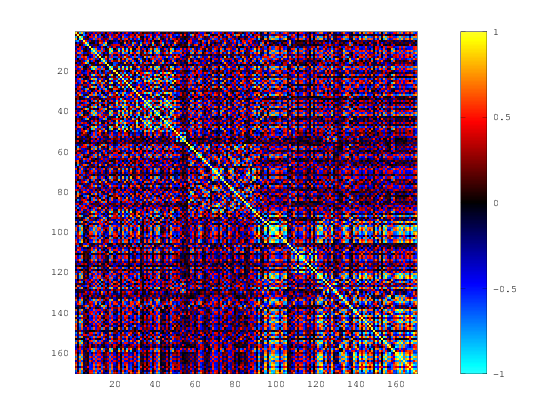

In [10]:
%%octave
nb_cluster =8;   # numb of clusters 
R = corr(y);
title('Spatial correlation matrix')
niak_visu_matrix(R), axis square

the cluster structure is clear, but noisy. Let's run a hierarchical clustering and see if we can recover it. 

     Percentage done : 0 5 10 15 20 25 30 36 40 46 50 55 60 65 70 75 80 85 91 95 100 Done ! 

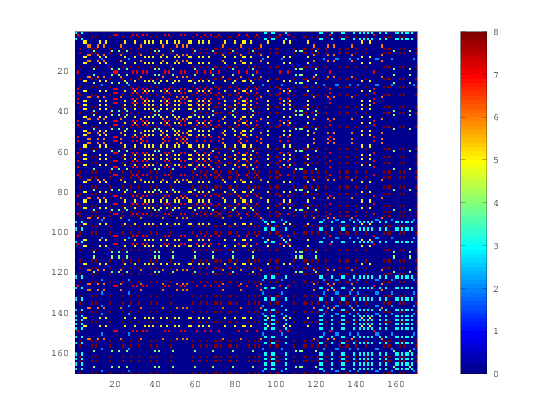

In [11]:
%%octave
hier = niak_hierarchical_clustering(R); % The similarity-based hierarchical clustering
part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); % threshold the hierarchy to get 3 clusters
niak_visu_part(part) % visualize the partition

If the clustering had done a perfect job, we would have squares on the diagonal.let's odre it

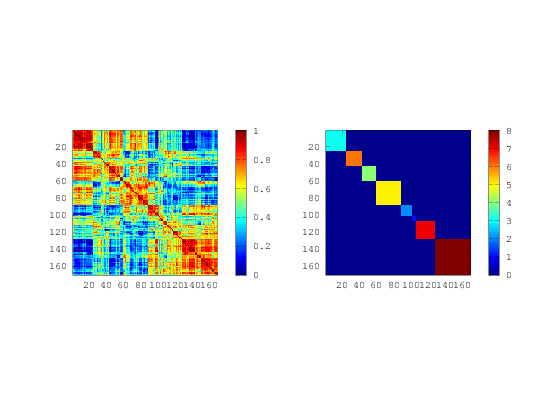

In [12]:
%%octave
order = niak_hier2order(hier); % order the regions based on the hierarchy
subplot(1,2,1)
# Re-order the correlation matrix
title('re-ordered correlation matrix')
imagesc(R(order,order)), axis square, colorbar
subplot(1,2,2)
# Show the re-ordered partition
title('re-ordered partition')
niak_visu_part(part(order)), axis square

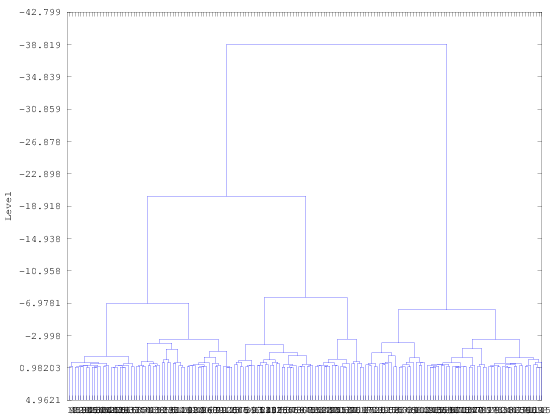

In [13]:
%octave niak_visu_dendrogram(hier)

## boostrap analysis of stable clusters
 

In [14]:
%%octave
nb_samp = 100;
opt_b.block_length = 1; # That's a parameter for the bootstrap. We treat the subjects as independent observations. 
for ss = 1:nb_samp
    niak_progress(ss,nb_samp)
    y_s = niak_bootstrap_tseries(y,opt_b); # Bootstrap the subjects
    R_s = corr(y_s); # compute the correlation matrix for the bootstrap sample
    hier = niak_hierarchical_clustering(R_s,struct('flag_verbose',false)); # replication the hierarchical clustering
    part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); # Cut the hierarchy to get clusters
    mat = niak_part2mat(part,true); # convert the partition into an adjacency matrix
    if ss == 1; stab = mat; else stab = stab+mat; end; # Add all adjacency matrices
end
stab = stab / nb_samp; # Divide by the number of replications to get the stability matrix

    Percentage done: 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100

Let's have a look at the stability matrix:

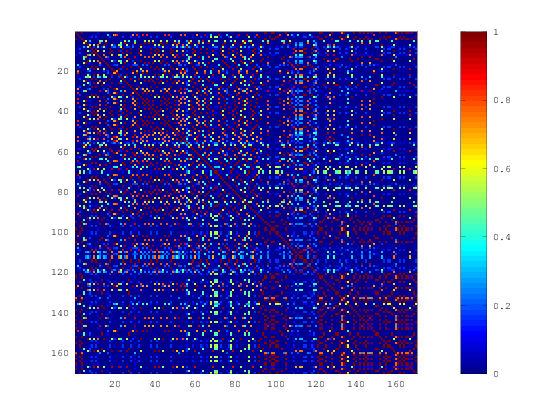

In [15]:
%octave imagesc(stab), axis square, colormap(jet), colorbar

In [48]:
%%octave -o nb_cluster
nb_cluster =7;   % # of clusters 
hier_consensus = niak_hierarchical_clustering(stab); # run a hierarchical clustering on the stability matrix
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',nb_cluster)); # cut the consensus hierarchy

     Percentage done : 0 5 10 15 20 25 30 36 40 46 50 55 60 65 70 75 80 85 91 95 100 Done ! 

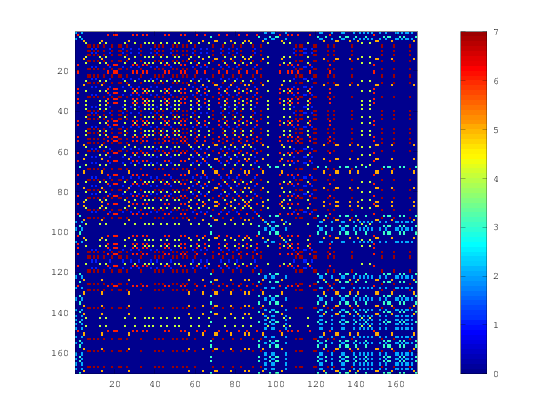

In [49]:
%octave niak_visu_part(part_consensus), axis square, colormap(jet) # visualize the consensus partition

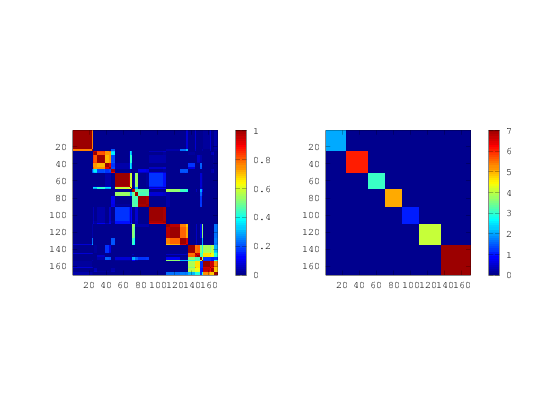

In [50]:
%%octave
order_consensus = niak_hier2order(hier_consensus); # order the regions based on the hierarchy
subplot(1,2,1)
# Re-order the correlation matrix
title('re-ordered consensus matrix')
imagesc(stab(order_consensus,order_consensus)), axis square, colorbar
subplot(1,2,2)
# Show the re-ordered partition
title('re-ordered partition')
niak_visu_part(part_consensus(order_consensus)), axis square

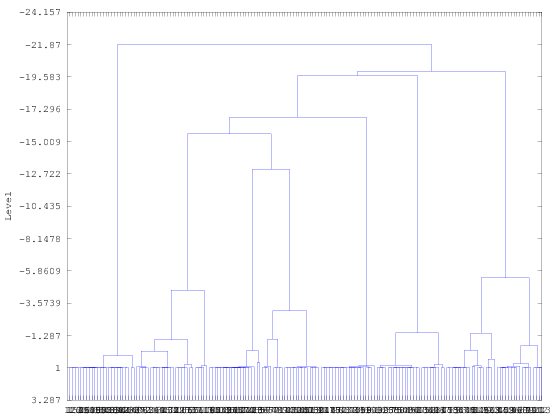

In [27]:
%octave niak_visu_dendrogram(hier_consensus)

ans =  1

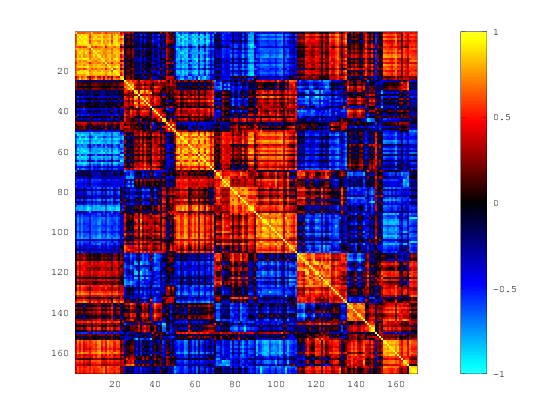

In [51]:
%%octave
# Re-order the correlation matrix
title('re-ordered correlation matrix')
niak_visu_matrix(R(order_consensus,order_consensus)), axis square, colorbar


In [52]:
%%octave -o stack
# calculate the mean cluster and save it
stack = [];
labels_y_order = LABELS_Y( order_consensus);
part_consensus_order = part_consensus(order_consensus);
y_order = y(:,order_consensus);
for ii = 1:nb_cluster
    fprintf('Cluster %i: \n',ii);
    label_y{ii} = sprintf('cluster_%i',ii);
    mask = zeros(size(part_consensus_order));
    mask = part_consensus_order == ii;
    mean_clust = mean(y_order(:,mask),2);
    stack = [stack mean_clust];
    labels_pheno = labels_y_order(mask);
    for ss = 1:size(labels_pheno)(1)
        fprintf('     %s \n',labels_pheno{ss})
    end
end

Cluster 1: 

     sub4_contrast_loss_event_vs_neut_event 

     sub2_rh 

     sub4_mental 

     sub3_win_event 

     sub4_neut_event 

     sub3_contrast_win_event_vs_loss_event 

     sub3_t 

     sub3_loss_event 

     sub1_win 

     sub3_lf 

     sub1_contrast_win_vs_loss 

     sub3_contrast_win_event_vs_neut_event 

     sub2_loss 

     sub5_mental 

     sub3_rnd 

     sub5_rf 

     sub4_contrast_rh_vs_lh 

     sub1_contrast_rf_vs_lf 

     sub1_lh 

     sub4_contrast_mental_vs_rnd 

Cluster 2: 

     sub1_fear 

     sub5_match 

     sub1_places 

     sub3_relation 

     sub2_tools 

     sub3_places 

     sub1_2bk 

     sub1_faces 

     sub4_fear 

     sub5_contrast_relation_vs_match 

     sub4_contrast_tools_vs_places 

     sub4_relation 

     sub3_contrast_2bk_vs_0bk 

     sub2_0bk 

     sub2_body 

     sub5_places 

     sub4_contrast_faces_vs_places 

     sub3_tools 

     sub3_faces 

     sub5_body 

     sub3_2bk 

     sub4_0bk 

     sub3_contrast_faces_vs_places 

     sub5_contrast_body_vs_places 

Cluster 3: 

     sub3_fear 

     sub1_match 

     sub5_contrast_tools_vs_places 

     sub2_places 

     sub2_contrast_relation_vs_match 

     sub5_relation 

     sub1_contrast_body_vs_places 

     sub4_places 

     sub5_2bk 

     sub1_tools 

     sub4_body 

     sub2_contrast_body_vs_places 

     sub2_relation 

     sub5_contrast_faces_vs_places 

     sub2_contrast_faces_vs_places 

     sub5_0bk 

     sub5_tools 

     sub3_lh 

     sub1_contrast_tools_vs_places 

Cluster 4: 

     sub1_contrast_loss_event_vs_neut_event 

     sub2_contrast_mental_vs_rnd 

     sub1_contrast_win_event_vs_neut_event 

     sub4_loss_event 

     sub5_neut_event 

     sub5_loss 

     sub3_rf 

     sub5_lf 

     sub5_win_event 

     sub1_win_event 

     sub2_loss_event 

     sub4_contrast_rf_vs_lf 

     sub3_win 

     sub3_contrast_rh_vs_lh 

     sub2_lh 

     sub5_rh 

     sub3_contrast_win_vs_loss 

     sub3_0bk 

     sub2_story 

     sub2_t 

     sub4_match 

     sub1_rnd 

     sub1_relation 

     sub5_contrast_win_event_vs_loss_event 

     sub2_faces 

Cluster 5: 

     sub5_fear 

     sub2_contrast_rh_vs_lh 

     sub5_contrast_rf_vs_lf 

     sub4_t 

     sub5_lh 

     sub1_lf 

     sub3_rh 

     sub2_rf 

     sub4_contrast_win_vs_loss 

     sub4_contrast_relation_vs_match 

     sub1_0bk 

     sub4_tools 

     sub2_contrast_win_event_vs_loss_event 

     sub2_contrast_tools_vs_places 

     sub3_contrast_body_vs_places 

     sub5_contrast_2bk_vs_0bk 

     sub1_body 

     sub3_match 

     sub5_faces 

     sub4_2bk 

     sub1_contrast_faces_vs_places 

Cluster 6: 

     sub2_fear 

     sub5_t 

     sub2_lf 

     sub2_contrast_rf_vs_lf 

     sub1_rf 

     sub1_neut_event 

     sub5_win 

     sub4_faces 

     sub1_loss 

     sub1_loss_event 

     sub2_match 

     sub2_win_event 

     sub1_contrast_relation_vs_match 

     sub4_loss 

     sub5_contrast_win_event_vs_neut_event 

     sub4_contrast_win_event_vs_loss_event 

     sub1_t 

     sub2_contrast_2bk_vs_0bk 

     sub1_contrast_mental_vs_rnd 

     sub3_story 

     sub5_story 

     sub2_contrast_win_event_vs_neut_event 

     sub1_mental 

     sub1_rh 

     sub2_rnd 

     sub3_contrast_mental_vs_rnd 

Cluster 7: 

     sub2_contrast_loss_event_vs_neut_event 

     sub3_contrast_relation_vs_match 

     sub5_contrast_win_vs_loss 

     sub3_body 

     sub3_contrast_rf_vs_lf 

     sub3_loss 

     sub4_win 

     sub3_contrast_tools_vs_places 

     sub4_lf 

     sub2_contrast_win_vs_loss 

     sub1_story 

     sub4_story 

     sub1_contrast_2bk_vs_0bk 

     sub4_contrast_2bk_vs_0bk 

     sub3_contrast_loss_event_vs_neut_event 

     sub1_contrast_rh_vs_lh 

     sub4_rnd 

     sub3_neut_event 

     sub5_contrast_loss_event_vs_neut_event 

     sub4_contrast_win_event_vs_neut_event 

     sub4_contrast_body_vs_places 

     sub2_neut_event 

     sub5_loss_event 

     sub1_contrast_win_event_vs_loss_event 

     sub2_win 

     sub4_win_event 

     sub2_2bk 

     sub5_contrast_rh_vs_lh 

     sub4_lh 

     sub4_rf 

     sub4_rh 

     sub5_contrast_mental_vs_rnd 

     sub5_rnd 

     sub2_mental 

     sub3_mental 

In [53]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0
print('NVoxels = {}'.format(np.sum(mask)))
print('Shape = {}'.format(mask.shape))

NVoxels = 59900
Shape = (53, 64, 52)


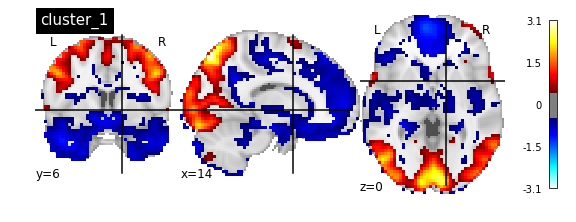

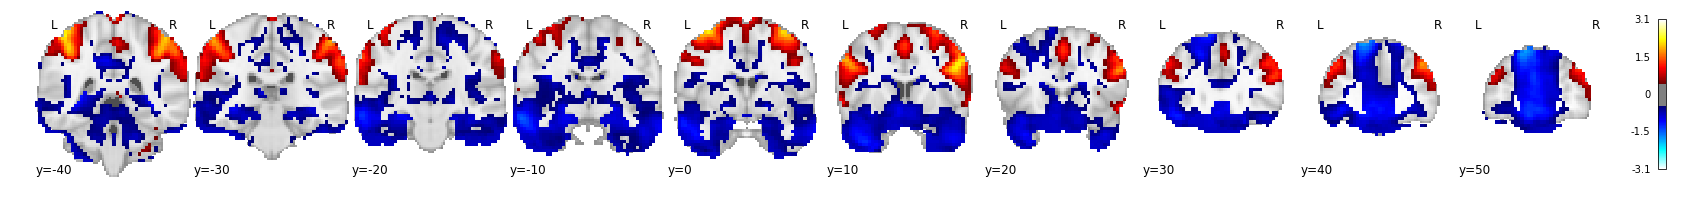

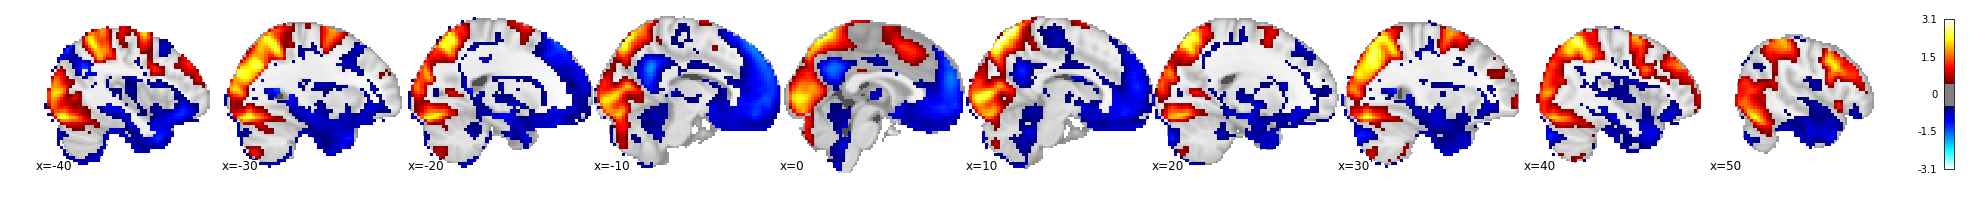

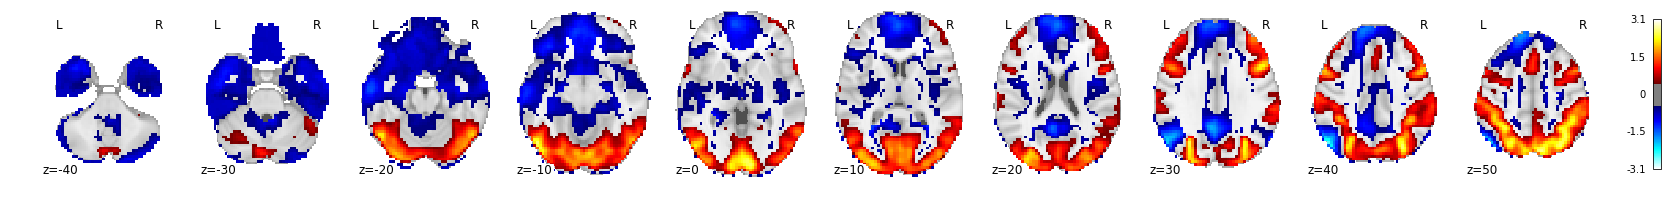

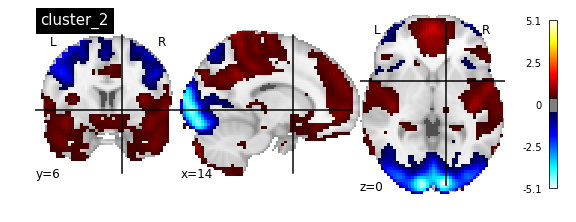

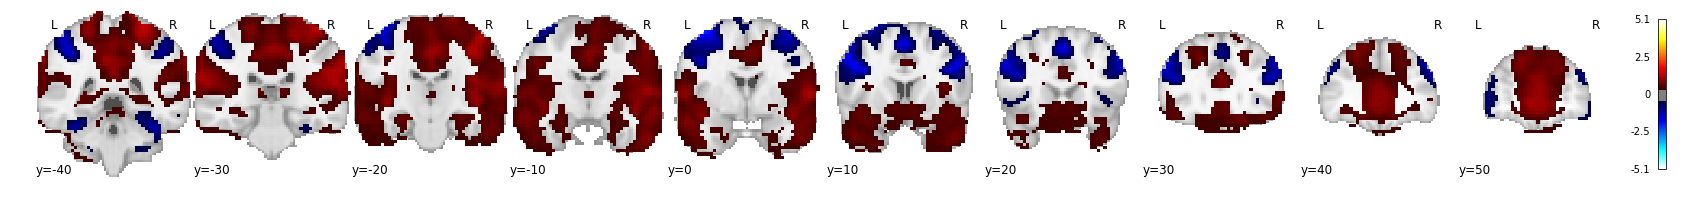

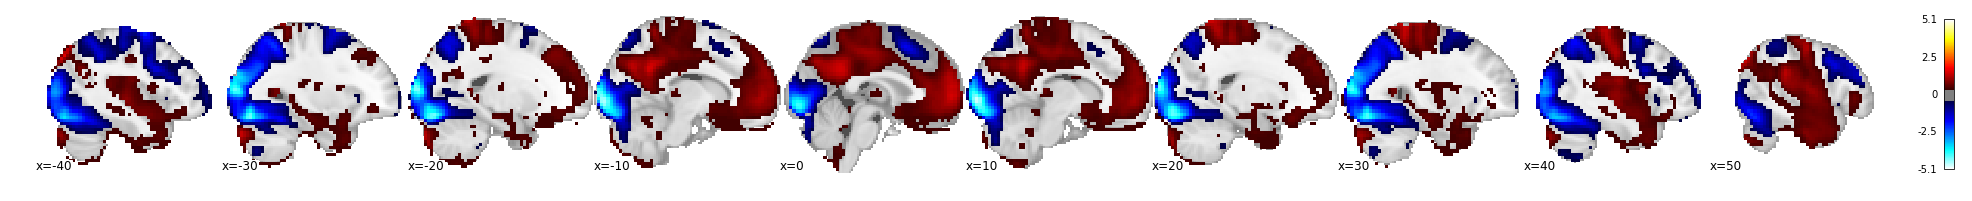

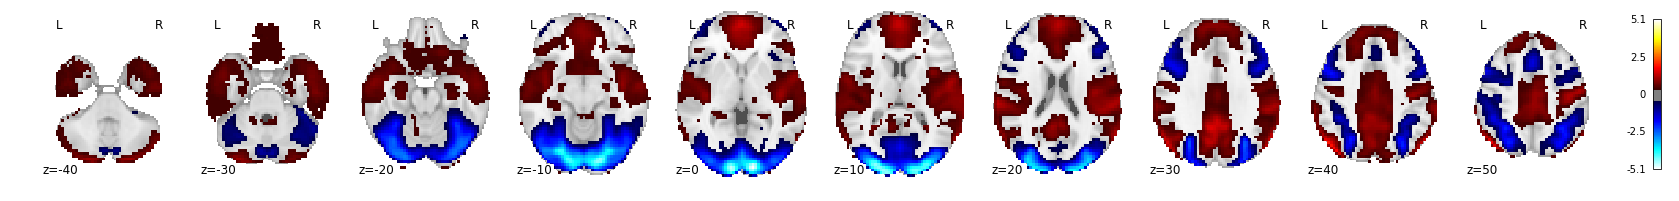

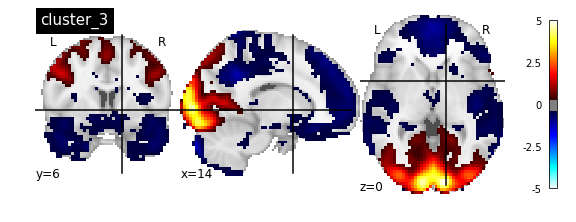

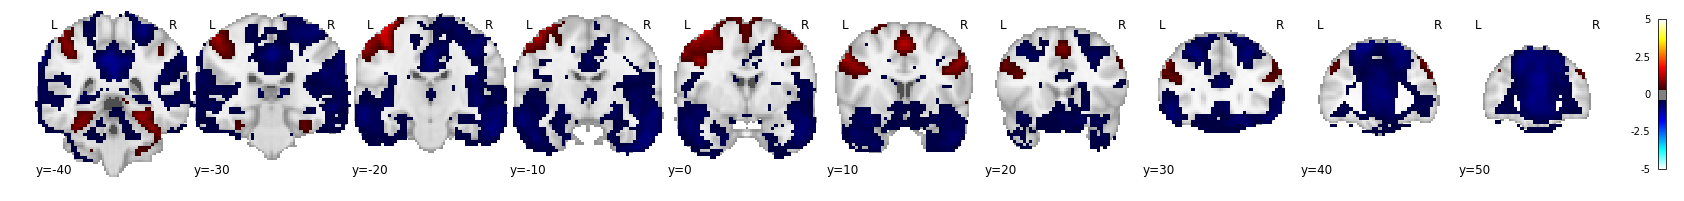

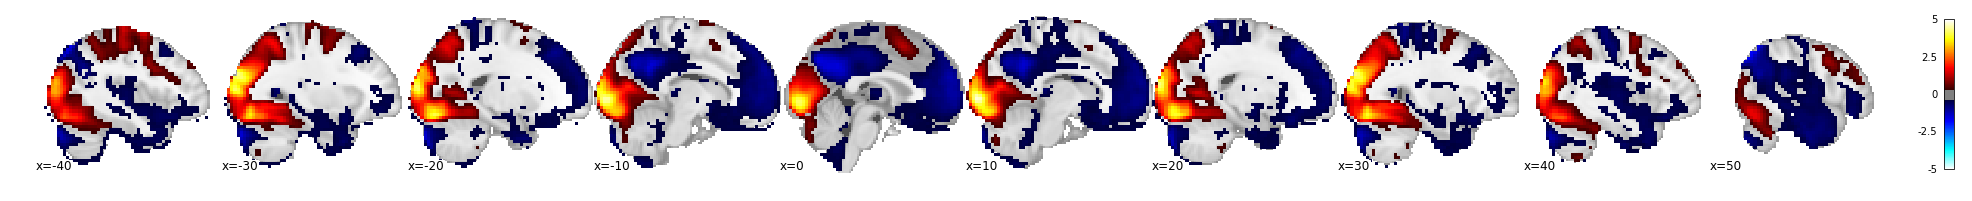

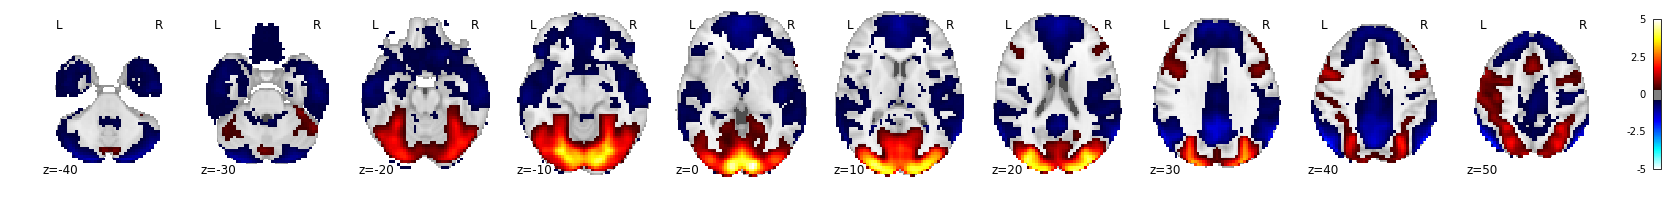

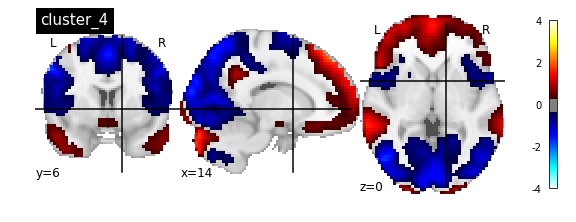

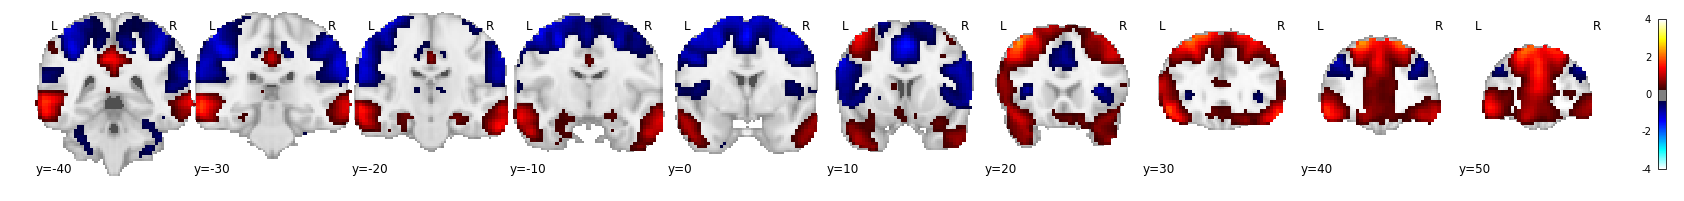

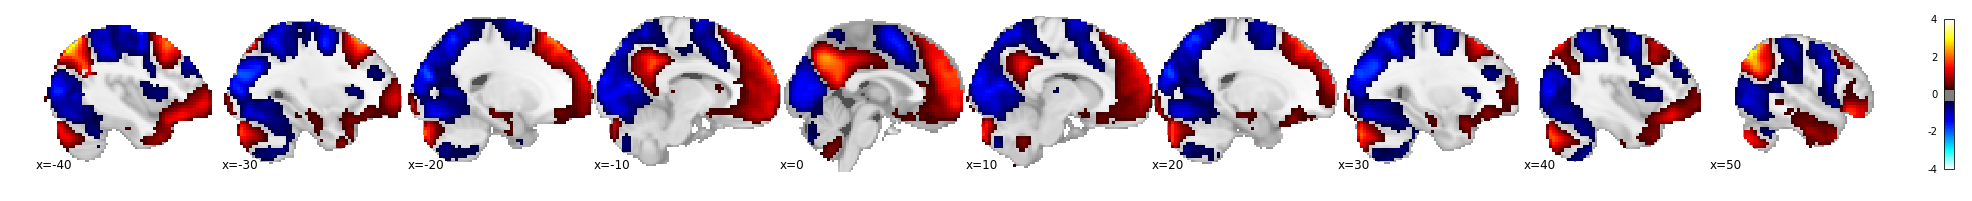

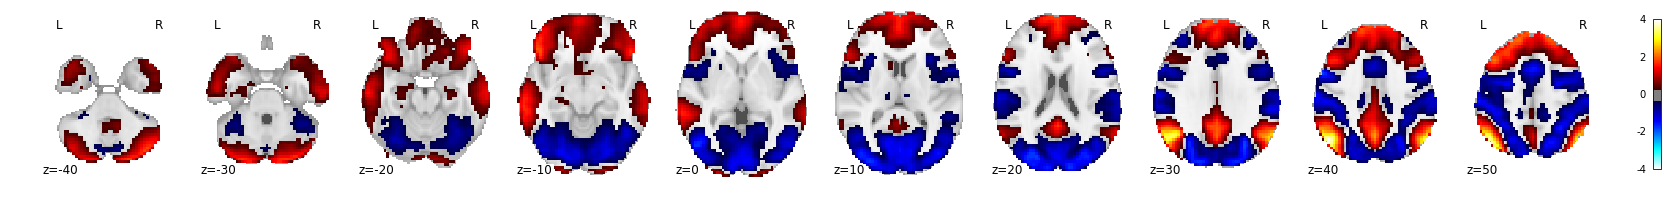

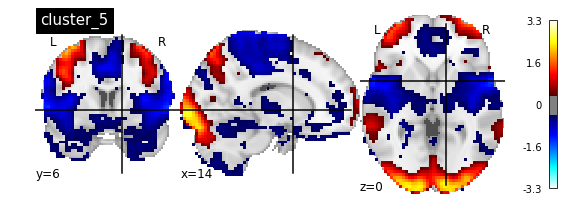

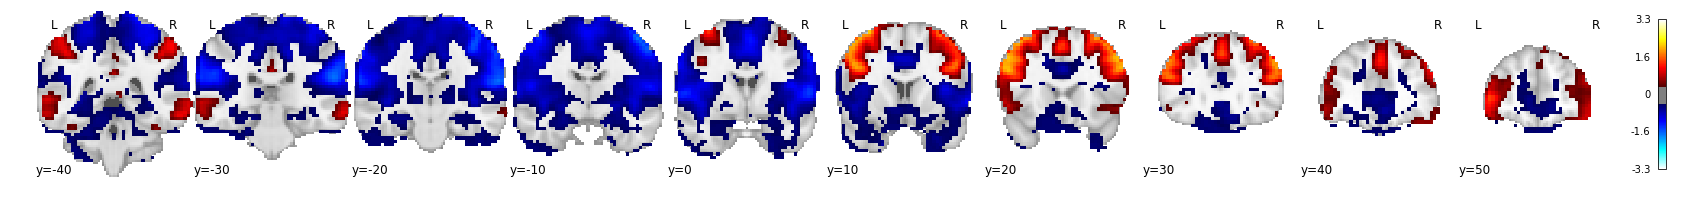

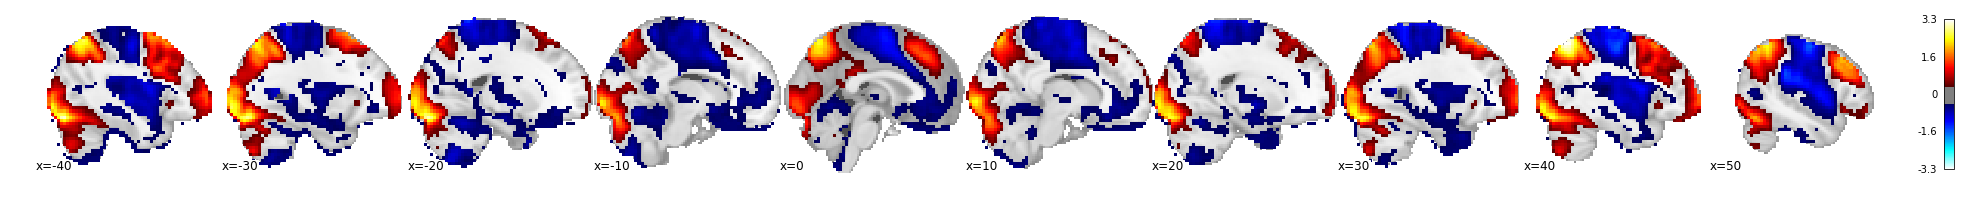

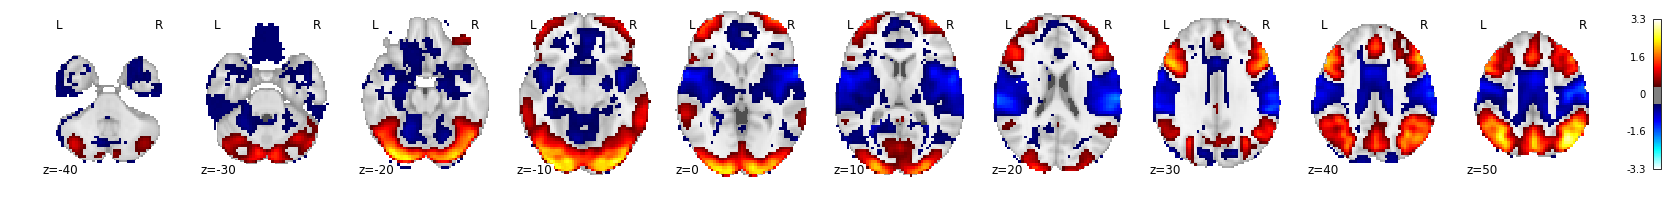

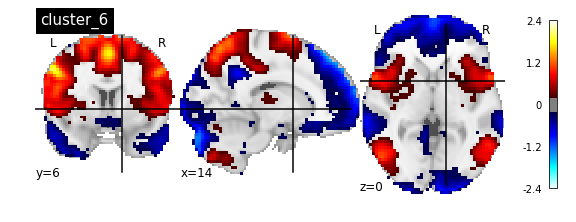

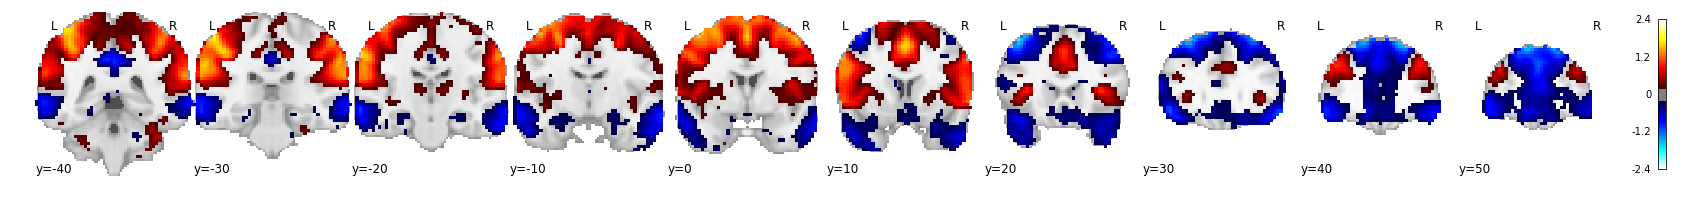

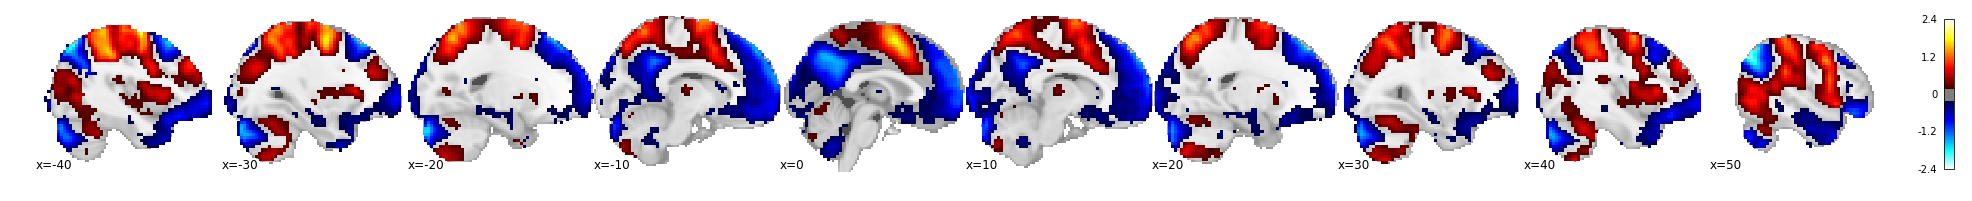

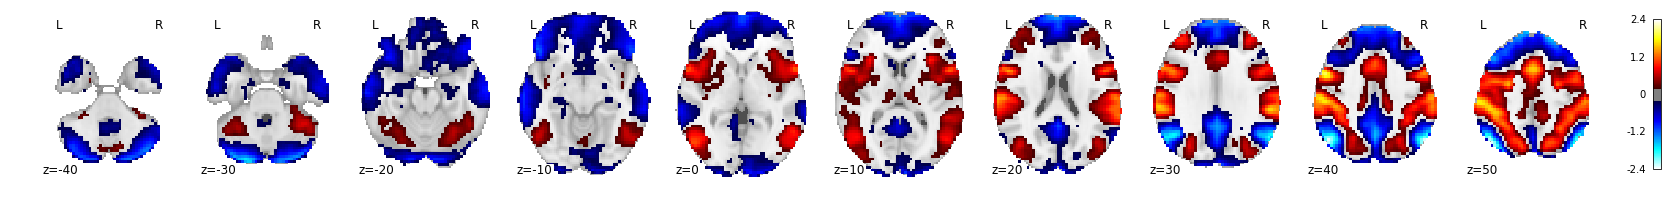

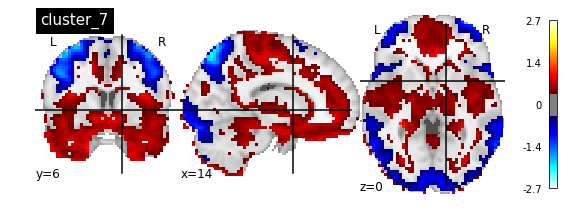

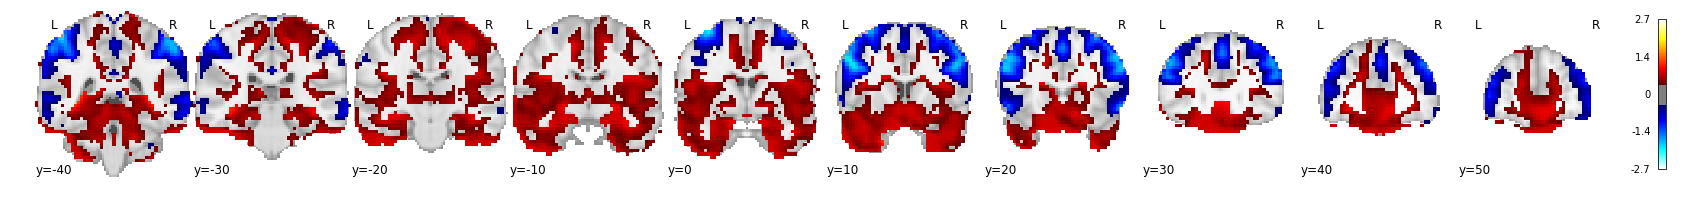

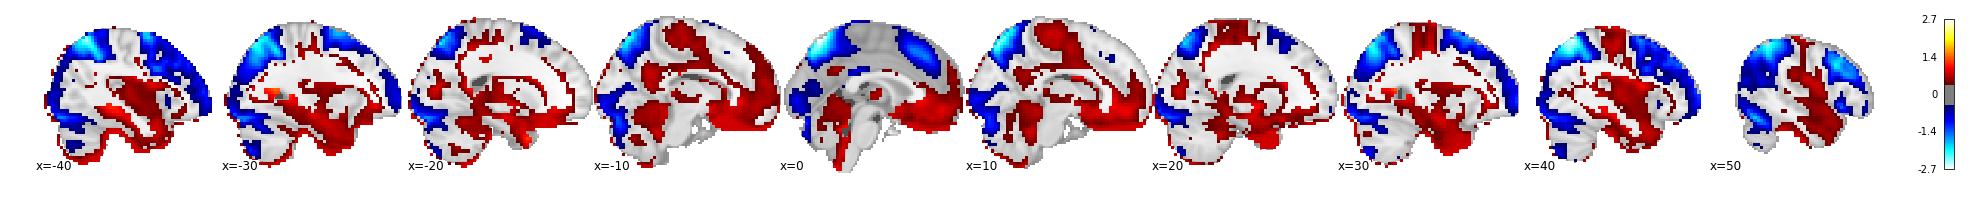

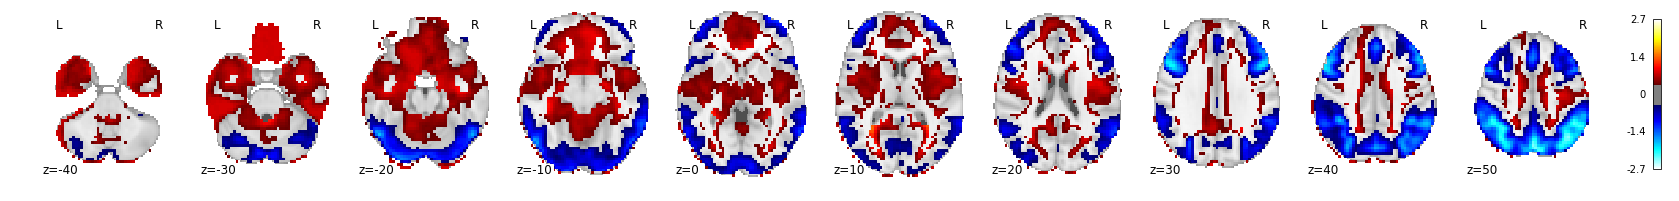

In [54]:
for cluster_num in range(int(nb_cluster)):
    sbt = stack[:,cluster_num]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt
    %octave_push mask sbt
    %octave vol = niak_tseries2vol(sbt,mask);
    %octave_pull vol
    sbt_img = nib.Nifti1Image(vol, affine=m_img.get_affine(), header=m_img.get_header())
    display = plotting.plot_stat_map(sbt_img,cut_coords=(14,6, 0),threshold= 'auto',
                                     title= "cluster_%s" % str(cluster_num+1))
    display = plotting.plot_stat_map(sbt_img, threshold= 'auto',
                                     display_mode='y',
                                     cut_coords= range(-40, 60, 10)
                                    )
    display = plotting.plot_stat_map(sbt_img, threshold='auto',
                                     display_mode='x',
                                     cut_coords= range(-40, 60, 10)
                                    )
    display = plotting.plot_stat_map(sbt_img, threshold='auto',
                                     display_mode='z',
                                     cut_coords= range(-40, 60, 10)
                                    )


ans =  1

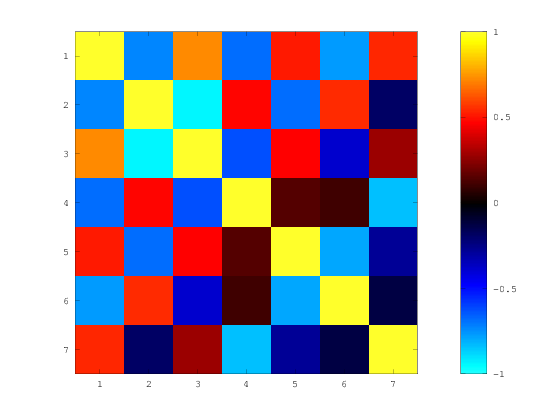

In [34]:
%%octave
Rc = corr(stack);
title('Spatial correlation matrix of clustered pheno')
niak_visu_matrix(Rc), axis square

In [35]:
%octave Rc

Rc =

   1.00000  -0.72730   0.72585  -0.68491   0.51075  -0.76960   0.53675

  -0.72730   1.00000  -0.93900   0.47451  -0.68151   0.54263  -0.19087

   0.72585  -0.93900   1.00000  -0.63232   0.46534  -0.38906   0.27679

  -0.68491   0.47451  -0.63232   1.00000   0.14231   0.10573  -0.84009

   0.51075  -0.68151   0.46534   0.14231   1.00000  -0.79651  -0.28678

  -0.76960   0.54263  -0.38906   0.10573  -0.79651   1.00000  -0.13067

   0.53675  -0.19087   0.27679  -0.84009  -0.28678  -0.13067   1.00000